In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import os
import re

from scipy.optimize import curve_fit
import skrf as rf
import scqubits as scq

from pyawr_utils import awrde_utils
from texttable import Texttable

# 1. Define Subroutines

### 1.1 Import Admittance Trace

In [2]:
def extract_admittance_traces(graph_name, number_of_ports, plot_admittance=False):

    print(f'Loading graph {graph_name}')
    
    graphs_dict = project.graph_dict  

    graph = graphs_dict[graph_name]        

    meas_dict = graph.measurements_dict
    
    matrix_element_name_to_frequencies = {}
    matrix_element_name_to_admittance = {}
    
    # find which matrix element the trace corresponds to
    matrix_element_regex = re.compile(r"Im\(Y\((?P<i>\d),(?P<j>\d).*")
    
    number_of_frequency_points = meas_dict[0].trace_data[0].shape[0]
    
    y_matrix = np.empty((number_of_frequency_points, number_of_ports, number_of_ports), dtype='complex')
    
    for meas in meas_dict.values():
        
        trace_data_list = meas.trace_data 
        trace_data = trace_data_list[0]


        frequencies = trace_data[:,0]
        admittance = trace_data[:,1]*1j
        
        match = matrix_element_regex.search(meas.measurement_name)
        groupdict = match.groupdict()
        
        i = int(groupdict['i']) - 1
        j = int(groupdict['j']) - 1
        
        
        y_matrix[:, i, j] = admittance
        if i != j:
            y_matrix[:, j, i] = admittance
        
        

        if plot_admittance:
            plt.plot(frequencies, admittance.imag, label='meas.measurement_name')

            plt.xlabel('Frequency (GHz)')
            plt.ylabel('Admittance')
            plt.legend()
            plt.title(graph_name)
            plt.show() 


    return frequencies, y_matrix

### 1.2 Extract circuit parameters from vector fitting

In [3]:
def get_vector_fit(frequencies, y_matrix, number_of_complex_poles=1, plot_fits=False):
    '''
    :param frequencies: frequencies in GHz
    :return: vector fit object
    '''
    
    number_of_ports = y_matrix.shape[1]
    
    assert number_of_ports == y_matrix.shape[2]
    
    frequencies_Hz = frequencies * 1e9
    network = rf.Network(frequency=frequencies_Hz, y=y_matrix)
    vector_fit = rf.VectorFitting(network)
    
    vector_fit.vector_fit(n_poles_real=0, n_poles_cmplx=number_of_complex_poles, parameter_type='y', fit_constant=False, fit_proportional=True)

    print('Found fit with the following errors:')
    for i in range(number_of_ports):
        for j in range(i, number_of_ports):

            print(f'\tRMS error y{i+1}{j+1} = {vector_fit.get_rms_error(i, j, parameter_type="y")}')
            
    if plot_fits:
        model_frequencies = np.linspace(frequencies[0], frequencies[-1], 10001)*1e9

        for i in range(number_of_ports):
            for j in range(i, number_of_ports):

                model_yij = vector_fit.get_model_response(i, j, model_frequencies)

                plt.plot(frequencies, np.imag(y_matrix[:,i,j]), linestyle='', marker='o', label='data')
                plt.plot(model_frequencies/1e9, np.imag(model_yij), label='fit')

                plt.xlabel('Frequency (GHz)')
                plt.ylabel('Amplitude')

                plt.ylim(-0.01, 0.01)

                plt.legend()

                plt.title(f'Y{i+1}{j+1} fit')
                plt.show()
                
    return vector_fit

In [50]:
def extract_circuit_parameters(vector_fit, number_of_ports, print_values=False):
    '''
    put residues into NxN matrices where N is number of ports
    '''
    
    poles = vector_fit.poles
    residues = vector_fit.residues
    proportional_coeff = vector_fit.proportional_coeff
    
    number_of_poles = len(poles)
    
    # complex poles
    if number_of_poles > 1:
        residues_reshaped = np.real(np.reshape(residues, (number_of_ports, number_of_ports, number_of_poles)))
    elif number_of_poles == 1:
        residues_reshaped = np.real(np.reshape(residues, (number_of_ports, number_of_ports)))

    # perform SVD on each NxN residue matrix
    # len is number of poles, elements are M NxN rank 1 matrices where M is the rank of the original NxN residue matrix 
    r_vectors = []
    ranks = []

    for k in range(number_of_poles):

        if number_of_poles > 1:
            residue = residues_reshaped[:,:,k]
        else:
            residue = residues_reshaped

        rank = np.linalg.matrix_rank(residue)
        ranks.append(rank)

        U, S, V = np.linalg.svd(residue)

        if print_values:
            print(f'pole {k} singular values: {S}')

        r_vectors_k = np.zeros((rank, number_of_ports))

        for rank_index in range(rank):
            r_vectors_k[rank_index, :] = np.sqrt(2*S[rank_index])*U[:,rank_index]

        r_vectors.append(r_vectors_k)

    if number_of_poles > 0:

        max_rank = np.max(ranks)


        # define circuit parameters for complex pole

        # total capacitances C_k
        C_k = 20e-15 # F
        C_ks = np.array([C_k]*number_of_poles*max_rank) 
        C_ks = np.reshape(C_ks, (number_of_poles, max_rank))


        # pole frequency omega_k
        omega_ks = np.imag(poles) # Hz * 2pi

        frequency_ks = omega_ks/2/np.pi # Hz

        if print_values:
            print(f'\nPole frequencies: {frequency_ks/1e9} GHz')


        # pole inductance L_k
        if print_values:
            print(f'\nMode inductances (nH)')
        L_ks = np.zeros((number_of_poles, max_rank))
        for k in range(number_of_poles):
            L_ks[k,:] = 1/(omega_ks[k]**2*C_ks[k,:]) # H

            if print_values:
                print(f'\tpole {k}: {L_ks[k,:] * 1e9}')


        # Coupling capacitances [C_ki]_j = sqrt(C_k)/(omega_k) [r_ki]_j

        C_coupling_ks = np.zeros((number_of_poles, max_rank, number_of_ports))

        if print_values:
            print('\nCoupling capacitances (fF)')
        for k in range(number_of_poles):
            for rank_index in range(max_rank):
                C_coupling_ks[k, rank_index, :] = np.sqrt(C_ks[k, rank_index])/omega_ks[k] * r_vectors[k][rank_index, :]


                if print_values:
                    print(f'\tpole {k}, rank index {rank_index}: {C_coupling_ks[k, rank_index, :] * 1e15}')


        # capacitance to ground C_kig = C_k - sum_j [C_ki]_j
        C_g_ks = np.zeros((number_of_poles, max_rank))

        if print_values:
            print('\nPole capacitance to ground (fF)')
        for k in range(number_of_poles):
            for rank_index in range(max_rank):
                C_g_ks[k, rank_index] = C_ks[k, rank_index] - np.sum(C_coupling_ks[k, rank_index, :])

                if print_values:
                    print(f'\tpole {k}, rank index {rank_index}: {C_g_ks[k, rank_index] * 1e15} fF')
    else:
        max_rank = 0

    # fit proportional capacitance C_n
    C_n = np.reshape(proportional_coeff, (number_of_ports, number_of_ports)) # F
    if print_values:
        print(f'\nproportional coefficients (fF): \n{C_n * 1e-15}')
    
    
    
    # define capacitance matrix

    first_term = 0
    second_term = 0
    for k in range(number_of_poles):

        omega = omega_ks[k]

        if omega == 0:
            continue

        for rank_index in range(max_rank):

            r_vector = r_vectors[k][rank_index, :]

            first_term += np.outer(r_vector, r_vector)/(omega**2)

            second_term += - np.sqrt(C_ks[k, rank_index])/omega * np.diag(r_vector)


    cap_matrix = C_n + first_term + second_term

    cap_matrix_fF = cap_matrix * 1e15

    if print_values:
        print('Capacitance Matrix (fF)')
        print(cap_matrix_fF)

    # analyze capacitance matrix to get capacitances to ground

    capacitance_to_grounds = np.sum(cap_matrix, -1)
    if print_values:
        print(f'\nNode capacitance to grounds: {capacitance_to_grounds * 1e15} fF')
    
    
    
    circuit_parameters = {}

    for k in range(number_of_poles):
        for rank_index in range(max_rank):
            circuit_parameters[f'pole_inductance_{k*number_of_poles + rank_index}'] = L_ks[k, rank_index] * 1e9 # nH
            circuit_parameters[f'pole_capacitance_ground_{k*number_of_poles + rank_index}'] = C_g_ks[k, rank_index] * 1e15 # fF

            for i in range(number_of_ports):
                circuit_parameters[f'coupling_capacitance_{k*number_of_poles + rank_index}_{i}'] = C_coupling_ks[k, rank_index, i] * 1e15 # fF

    for i in range(number_of_ports):

        circuit_parameters[f'node_capacitance_ground_{i}'] = capacitance_to_grounds[i] * 1e15 # fF

        for j in range(number_of_ports):

            if i != j:
                circuit_parameters[f'internode_capacitance_{i}{j}'] = -cap_matrix_fF[i, j] # fF



    return circuit_parameters, number_of_poles, max_rank

### 1.3 Find Qubit and Coupler Capacitances

In [27]:
def find_qubit_capacitance(number_of_complex_poles=1, plot_fits=False):
    
    graph_name = 'Y_q'
    number_of_ports = 1
    
    frequencies, y_matrix = extract_admittance_traces(graph_name, number_of_ports)
    vector_fit = get_vector_fit(frequencies, y_matrix, number_of_complex_poles=number_of_complex_poles, plot_fits=plot_fits)
    circuit_parameters, number_of_poles, max_rank = extract_circuit_parameters(vector_fit, number_of_ports)
    
    C_q_tot = 0

    for k in range(number_of_poles):
        for rank_index in range(max_rank):
            C_q_tot += circuit_parameters[f'coupling_capacitance_{k*number_of_poles + rank_index}_{0}']

    C_q_tot += circuit_parameters[f'node_capacitance_ground_{0}']
    

    return C_q_tot
    

In [26]:
def find_coupler_capacitance(number_of_complex_poles=1, plot_fits=False):
    
    graph_name = 'Y_c'
    number_of_ports = 1
    
    frequencies, y_matrix = extract_admittance_traces(graph_name, number_of_ports)
    vector_fit = get_vector_fit(frequencies, y_matrix, number_of_complex_poles=number_of_complex_poles, plot_fits=plot_fits)
    circuit_parameters, number_of_poles, max_rank = extract_circuit_parameters(vector_fit, number_of_ports)
    
    C_c_tot = 0

    for k in range(number_of_poles):
        for rank_index in range(max_rank):
            C_c_tot += circuit_parameters[f'coupling_capacitance_{k*number_of_poles + rank_index}_{0}']

    C_c_tot += circuit_parameters[f'node_capacitance_ground_{0}']

    return C_c_tot
    

### 1.4 Set MWO Parameters

In [7]:
def set_qubit_frequency_equation(project, qubit_frequency):
    '''
    frequency in Hz
    '''
    global_def_dict = project.global_definitions_dict

    global_def = global_def_dict['Global Definitions']

    equations_dict = global_def.equations_dict

    for equation in equations_dict.values():
        if equation.equation_name == 'f_q':
            equation.equation_value = qubit_frequency
            
def set_coupler_frequency_equation(project, coupler_frequency):
    '''
    frequency in Hz
    '''
    global_def_dict = project.global_definitions_dict

    global_def = global_def_dict['Global Definitions']

    equations_dict = global_def.equations_dict

    for equation in equations_dict.values():
        if equation.equation_name == 'f_c':
            equation.equation_value = coupler_frequency
            
def set_qubit_capacitance_equation(project, qubit_capacitance):
    '''
    capacitance in F
    '''
    global_def_dict = project.global_definitions_dict

    global_def = global_def_dict['Global Definitions']

    equations_dict = global_def.equations_dict

    for equation in equations_dict.values():
        if equation.equation_name == 'C_q':
            equation.equation_value = qubit_capacitance
            
def set_coupler_capacitance_equation(project, coupler_capacitance):
    '''
    capacitance in F
    '''
    global_def_dict = project.global_definitions_dict

    global_def = global_def_dict['Global Definitions']

    equations_dict = global_def.equations_dict

    for equation in equations_dict.values():
        if equation.equation_name == 'C_c':
            equation.equation_value = coupler_capacitance

### 1.5 Extract coupling strength from avoided crossing

In [8]:
def create_qq_circuit_yaml(circuit_parameters, num_poles, num_ranks, num_ports, junction_EJs, parasitic_capacitances):
    
    yaml_str = 'branches:'
    
    total_num_poles = num_poles * num_ranks
    num_nodes = 1 + num_ports + total_num_poles
    
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            # add capacitances
            capacitance = None
    
            if i == 0:
                # ground to everything (capacitances)
                if j in range(1, 1 + num_ports):
                    capacitance = circuit_parameters[f'node_capacitance_ground_{j - 1}']
                elif j in range(1 + num_ports, 1 + num_ports + total_num_poles):
                    capacitance = circuit_parameters[f'pole_capacitance_ground_{j - 1 - total_num_poles}']
                    
                    inductance = circuit_parameters[f'pole_inductance_{j - 1 - total_num_poles}']
                    yaml_str += f'\n- ["L", {i}, {j}, {inductance}nH]'
                    
            elif i in range(1, 1 + num_ports):
                # q1, q2, c to everything (capacitance)
                if j in range(1, 1 + num_ports):
                    capacitance = circuit_parameters[f'internode_capacitance_{i - 1}{j - 1}']
                elif j in range(1 + num_ports, 1 + num_ports + total_num_poles):
                    capacitance = circuit_parameters[f'coupling_capacitance_{j - 1 - total_num_poles}_{i - 1}']
            
            if not capacitance is None:
                yaml_str += f'\n- ["C", {i}, {j}, {capacitance}fF]'
                
    # junctions: [EJ_q1, EJ_q2]
    EJ_q1, EJ_q2 = junction_EJs
    
    # parasitic capacitances: [C_parasitic_q1, C_parasitic_q2]
    C_parasitic_q1, C_parasitic_q2 = parasitic_capacitances
    
    # add qubit junctions
    yaml_str += f'\n- ["JJ", 0, 1, EJ_q1 = {EJ_q1}, {C_parasitic_q1}fF]'
    yaml_str += f'\n- ["JJ", 0, 2, EJ_q2 = {EJ_q2}, {C_parasitic_q2}fF]'
    
    return yaml_str
                    

In [9]:
def create_qq_circuit(circuit_parameters, num_poles, num_ranks, num_ports, junction_EJs, parasitic_capacitances):   
    circuit_yaml = create_qq_circuit_yaml(circuit_parameters, num_poles, num_ranks, num_ports, junction_EJs, parasitic_capacitances)
    circuit = scq.Circuit(circuit_yaml, from_file=False, ext_basis='harmonic', basis_completion='canonical')

    num_modes = num_ports + num_poles * num_ranks
    circuit.configure(np.identity(num_modes))
    
    circuit.cutoff_n_1 = 9
    circuit.cutoff_n_2 = 9
    circuit.cutoff_ext_3 = 4
    circuit.cutoff_ext_4 = 4
    
    return circuit

In [10]:
def create_qq_circuit_hierarchical(circuit_parameters, num_poles, num_ranks, num_ports, junction_EJs, parasitic_capacitances):   
    circuit_yaml = create_qq_circuit_yaml(circuit_parameters, num_poles, num_ranks, num_ports, junction_EJs, parasitic_capacitances)
    circuit = scq.Circuit(circuit_yaml, from_file=False, ext_basis='harmonic', basis_completion='canonical')

    circuit.cutoff_n_1 = 20
    circuit.cutoff_n_2 = 20
    circuit.cutoff_ext_3 = 20
    circuit.cutoff_ext_4 = 20

    system_hierarchy = [[1, 2], [3], [4]]

    system_hierarchy_trunc_dims = [10, 5, 5]
    ext_basis = ['harmonic', 'harmonic', 'harmonic']
    num_modes = num_ports + num_poles * num_ranks
    circuit.configure(np.identity(num_modes), system_hierarchy=system_hierarchy, subsystem_trunc_dims=system_hierarchy_trunc_dims, ext_basis=ext_basis)
    
    
    return circuit

In [11]:
def qubit_frequency_vs_EJ_fit(x, a, b):
    return np.sqrt(8*x*a) + b

def EJ_vs_frequency(f, a, b):
    return np.power(f - b, 2)/(8*a)

In [12]:
def coupling_strength_fit(x, x0, Omega, a, c):
    return np.sqrt(np.power(a*(x-x0), 2) + np.power(Omega, 2)) + c

def coupling_strength_fit(x, x0, Omega, a):
    return np.sqrt(np.power(a*(x-x0), 2) + np.power(Omega, 2))

In [13]:
def extract_coupling_strength_from_avoided_crossing(graph_name, number_of_ports, qubit_parameters, coupler_frequency, coupling_fit_initial_guess=None):
    
    frequencies, y_matrix = extract_admittance_traces(graph_name, number_of_ports)
    vector_fit = get_vector_fit(frequencies, y_matrix, number_of_complex_poles=1, plot_fits=False)
    circuit_parameters, number_of_poles, max_rank = extract_circuit_parameters(vector_fit, number_of_ports)
    
    ### parameters
    
    qubit_frequency = qubit_parameters['qubit_frequency']
    qubit_frequency_sweep = qubit_parameters['qubit_frequency_sweep']
    C_parasitic_q = qubit_parameters['C_parasitic_q']
    C_q_tot = qubit_parameters['C_q_tot']
    
    E_c = e*e/(2*C_q_tot*1e-15)/h/1e6 # MHz
    
    
    EJ_guess = np.power(qubit_frequency + E_c*1e-3, 2)/(8*E_c*1e-3)

    
    ### first sweep Q1 with Q2 far away
    
    junction_EJs = (EJ_guess, 4*EJ_guess)
    parasitic_capacitances = (C_parasitic_q, C_parasitic_q)
    
    
    circuit = create_qq_circuit(circuit_parameters, number_of_poles, max_rank, number_of_ports, junction_EJs, parasitic_capacitances)

    EJ_sweep = np.linspace(0.75*EJ_guess, 1.5*EJ_guess, 5)

    # Q1 bare frequencies
    
    q1_EJs = np.copy(EJ_sweep)
    q1_bare_frequencies = np.zeros(len(q1_EJs))
    for i in range(len(EJ_sweep)):
        EJ = EJ_sweep[i]
        circuit.EJ_q1 = EJ
        
        evals = circuit.eigenvals(2)

        if coupler_frequency > qubit_frequency:
            evals = circuit.eigenvals(2)
            q1_bare_frequencies[i] = evals[1] - evals[0]
        else:
            evals = circuit.eigenvals(3)
            print(f'q1 bare evals: {(np.array(evals)-evals[0])*1000}')
            q1_bare_frequencies[i] = evals[2] - evals[1]
        
    
    
    plt.plot(q1_EJs, q1_bare_frequencies*1000, marker='o', linestyle='', label='data')
    
    initial_guess = [E_c*1e-3, -E_c*1e-3]
    fit_EJs = np.linspace(EJ_sweep[0], EJ_sweep[-1], 1001)
    plt.plot(fit_EJs, qubit_frequency_vs_EJ_fit(fit_EJs, *initial_guess)*1000, label='initial guess')
    
    popt, pcov = curve_fit(qubit_frequency_vs_EJ_fit, q1_EJs, q1_bare_frequencies, p0=initial_guess)
   
    plt.plot(fit_EJs, qubit_frequency_vs_EJ_fit(fit_EJs, *popt)*1000, label='fit')
    
    
    plt.xlabel('EJ (GHz)')
    plt.ylabel('Frequency (MHz)')
    
    plt.title('Q1 bare frequencies fit')

    plt.legend()
    plt.show()
    
    def create_frequency_to_EJ_lambda(_popt):
        return lambda f: EJ_vs_frequency(f, *_popt)

    q1_frequency_to_EJ = create_frequency_to_EJ_lambda(popt)
    
    # Q2 bare frequencies
    circuit.EJ_q1 = 4*EJ_guess
    
    q2_EJs = np.copy(EJ_sweep)
    q2_bare_frequencies = np.zeros(len(q2_EJs))
    for i in range(len(EJ_sweep)):
        EJ = EJ_sweep[i]
        circuit.EJ_q2 = EJ
        

        if coupler_frequency > qubit_frequency:
            evals = circuit.eigenvals(2)
            q2_bare_frequencies[i] = evals[1] - evals[0]
        else:
            evals = circuit.eigenvals(3)
            q2_bare_frequencies[i] = evals[2] - evals[1]
            
    
    
    plt.plot(q2_EJs, q2_bare_frequencies*1000, marker='o', linestyle='', label='data')
    
    initial_guess = [E_c*1e-3, -E_c*1e-3]
    fit_EJs = np.linspace(EJ_sweep[0], EJ_sweep[-1], 1001)
    plt.plot(fit_EJs, qubit_frequency_vs_EJ_fit(fit_EJs, *initial_guess)*1000, label='initial guess')
    
    popt, pcov = curve_fit(qubit_frequency_vs_EJ_fit, q2_EJs, q2_bare_frequencies, p0=initial_guess)
   
    plt.plot(fit_EJs, qubit_frequency_vs_EJ_fit(fit_EJs, *popt)*1000, label='fit')
    
    
    plt.xlabel('EJ (GHz)')
    plt.ylabel('Frequency (MHz)')
    
    plt.title('Q2 bare frequencies fit')

    plt.legend()
    plt.show()
    
    q2_frequency_to_EJ = create_frequency_to_EJ_lambda(popt)
    
    
    
    ### now sweep Q2 through Q1 to find avoided crossing
    
    EJ_q1_static = q1_frequency_to_EJ(qubit_frequency)
    EJ_q2_sweep = q2_frequency_to_EJ(qubit_frequency_sweep)
    
    avoided_crossing_frequencies = np.zeros((len(EJ_q2_sweep), 2))
    
    circuit.EJ_q1 = EJ_q1_static
    
    for i in range(len(EJ_q2_sweep)):
        circuit.EJ_q2 = EJ_q2_sweep[i]
        
        if coupler_frequency > qubit_frequency:
            evals = circuit.eigenvals(3)
            avoided_crossing_frequencies[i,0] = evals[1] - evals[0]
            avoided_crossing_frequencies[i,1] = evals[2] - evals[0]
        else:
            evals = circuit.eigenvals(4)
            avoided_crossing_frequencies[i,0] = evals[2] - evals[0]
            avoided_crossing_frequencies[i,1] = evals[3] - evals[0]
        
    plt.plot(qubit_frequency_sweep*1000, avoided_crossing_frequencies[:,0]*1000, label='Q1 frequency')
    plt.plot(qubit_frequency_sweep*1000, avoided_crossing_frequencies[:,1]*1000, label='Q2 frequency')
    
#     plt.plot(q2_bare_frequencies*1000, q2_bare_frequencies*1000, linestyle=':', color='black', label='Q2 bare frequency')
#     plt.axhline(q1_bare_frequencies[len(q1_bare_frequencies)//2]*1000, linestyle='dashed', color='black', label='Q1 bare frequency')
    
    plt.xlabel('Q2 sweep frequency (MHz)')
    plt.ylabel('Frequency (MHz)')
        
    plt.legend() 
    plt.title('Q1 - Q2 Avoided Crossing')
    
    plt.show()
    
    ### calculate coupling strength from difference
    
    difference = avoided_crossing_frequencies[:,1] - avoided_crossing_frequencies[:,0]
    

    plt.plot(qubit_frequency_sweep, difference, marker='o', linestyle='', label='data')

    if coupling_fit_initial_guess is None:
        coupling_fit_initial_guess = [qubit_frequency, 0.1, 0.6, 0]
        coupling_fit_initial_guess = [qubit_frequency, np.min(difference), 0.025]
#     print(f'coupling_fit_initial_guess: {coupling_fit_initial_guess}')
        
#     bounds = ((0,0,0,-0.1), (2*qubit_frequency, qubit_frequency, np.inf, 0.1))
    bounds = ((0,0,0), (2*qubit_frequency, qubit_frequency, np.inf))

    fit_frequencies = np.linspace(qubit_frequency_sweep[0], qubit_frequency_sweep[-1], 1001)

    plt.plot(fit_frequencies, coupling_strength_fit(fit_frequencies, *coupling_fit_initial_guess), label='initial guess')


    popt, pcov = curve_fit(coupling_strength_fit, qubit_frequency_sweep, difference, p0=coupling_fit_initial_guess, bounds=bounds)
    plt.plot(fit_frequencies, coupling_strength_fit(fit_frequencies, *popt), label='fit')

    plt.xlabel('Frequency (GHz)')
    plt.ylabel('Frequency Difference (GHz)')

    plt.legend()

    plt.show()

#     x0, Omega, a, c = popt
    x0, Omega, a = popt

    c = 0
    print(f'popt for coupling strength fit: {popt}')
    coupling_strength = (np.abs(Omega) + c)/2*1000 # MHz

    # coupling is negative if coupler is above qubit in frequency
    # but this is not always true, e.g. for rung coupling it's mostly fixed capacitive so positive
#     if coupler_frequency > qubit_frequency:
#         coupling_strength *= -1
    
    return coupling_strength

# 2.

In [14]:
awrde = awrde_utils.establish_link()   #Establish link between Python and AWRDE
project = awrde_utils.Project(awrde)    #Assign object variable to Project class
#
project_name = project.project_name      #Get name of currently open project

expected_project_name = '8Q_triangle_lattice_capacitave_coupling_vector_fitting.emp'
try:
    assert project_name == expected_project_name
except:
    print(f'Need to open correct project. Got {project_name}, expected {expected_project_name}')
else:
    print(f'Opened project: {project_name}')
    
project.simulate_analyze()

Need to open correct project. Got 8Q_triangle_lattice_capacitave_coupling _vector_fitting.emp, expected 8Q_triangle_lattice_capacitave_coupling_vector_fitting.emp


True

In [17]:
h = 6.626e-34
hbar = h/(2*np.pi)
e = 1.6e-19 # Coulombs

Phi0 = h/(2*e)

Loading graph Y_q
Found fit with the following errors:
	RMS error y11 = 1.037926948616545e-05


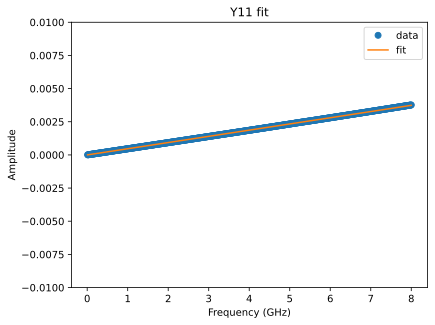

[]
[]
0
Setting qubit capacitance to 74.35073505201379 fF

Loading graph Y_c
Found fit with the following errors:
	RMS error y11 = 1.0200674235334477e-06


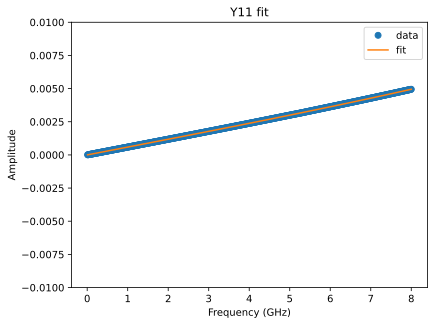

[-34210.10075813+1.45538351e+11j]
[[3.72038248e+08+95.49909409j]]
1
Setting coupler capacitance to 93.69970697573673 fF


In [45]:
C_q_tot = find_qubit_capacitance(number_of_complex_poles=0, plot_fits=True)

print(f'Setting qubit capacitance to {C_q_tot} fF\n')
set_qubit_capacitance_equation(project, C_q_tot*1e-15)


C_c_tot = find_coupler_capacitance(number_of_complex_poles=1, plot_fits=True)

print(f'Setting coupler capacitance to {C_c_tot} fF')
set_coupler_capacitance_equation(project, C_c_tot*1e-15)



In [46]:
# set qubit parameters

# set qubit frequency and define qubit frequency sweep for avoided crossing
qubit_frequency = 5 # GHz
set_qubit_frequency_equation(project, qubit_frequency*1e9)

frequency_sweep_range = 0.02
frequency_sweep_points = 11
qubit_frequency_sweep = np.linspace(qubit_frequency - frequency_sweep_range, qubit_frequency + frequency_sweep_range, frequency_sweep_points)

C_parasitic_q = 12 # fF

qubit_parameters = {}

qubit_parameters['qubit_frequency'] = qubit_frequency
qubit_parameters['qubit_frequency_sweep'] = qubit_frequency_sweep
qubit_parameters['C_parasitic_q'] = C_parasitic_q
qubit_parameters['C_q_tot'] = C_q_tot


In [47]:
# define coupler frequencies

num_lower_points = 31
num_higher_points = 11

num_lower_points = 0
num_higher_points = 2

coupler_frequencies_lower = np.linspace(1, 4, num_lower_points) # GHz
coupler_frequencies_higher = np.linspace(6, 7, num_higher_points) # GHz

coupler_frequencies = np.concatenate([coupler_frequencies_lower, coupler_frequencies_higher])

print(coupler_frequencies)


[6. 7.]


In [48]:
coupler_frequency_to_coupling_fit_initial_guess = {}

coupler_frequency_to_coupling_fit_initial_guess['6'] = [4.69228133, 0.10660338, 0.63233435, 0.09499935]

Setting coupler frequency to 6.0 GHz
Loading graph Y_qq_leg
Found fit with the following errors:
	RMS error y11 = 1.0356587399226721e-05
	RMS error y12 = 3.671386466533411e-07
	RMS error y22 = 1.022789004459284e-05
[-9.78217507e-06+3.70443974e+10j]
[[228453.63463129-2.84416045e-08j]
 [229468.68984199-2.87087534e-08j]
 [229468.68984199-2.86994244e-08j]
 [230021.90882138-2.84416045e-08j]]
1


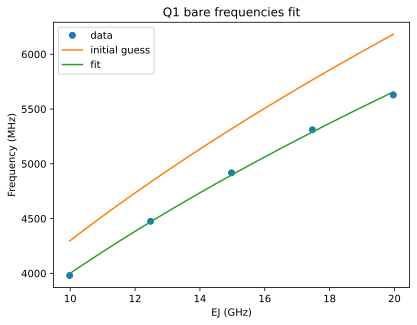

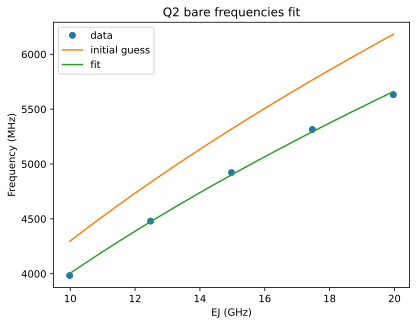

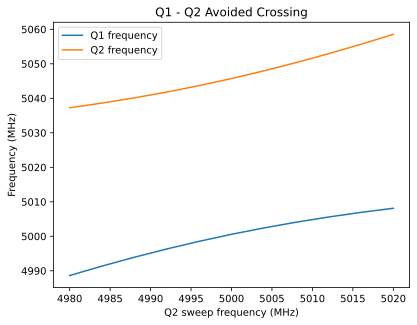

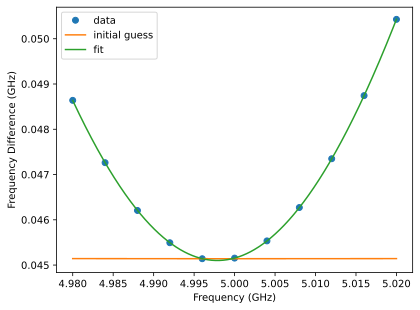

popt for coupling strength fit: [4.99786175 0.04510101 1.01921927]
coupling strength leg: 22.550505893712845 MHz
Loading graph Y_qq_rung
Found fit with the following errors:
	RMS error y11 = 1.0343868688809297e-05
	RMS error y12 = 3.5151649306111983e-07
	RMS error y22 = 1.0392282431818414e-05
[-0.+3.71282242e+10j]
[[2.30511610e+05+2.17111485e-10j]
 [8.83202837e+02+8.48091738e-13j]
 [8.83202837e+02+8.48091738e-13j]
 [8.25789729e-01+0.00000000e+00j]]
1


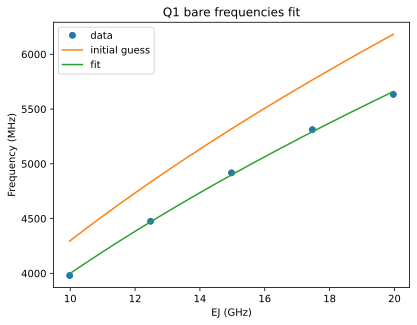

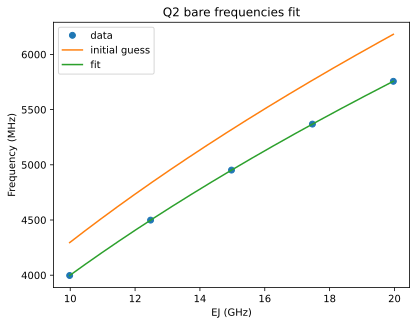

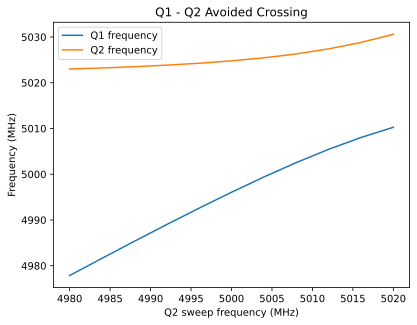

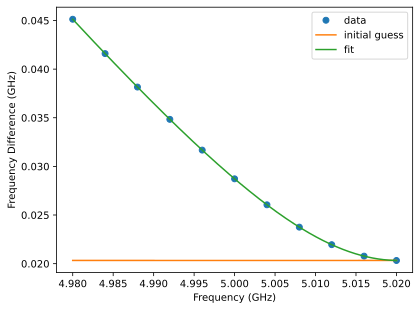

popt for coupling strength fit: [5.02029917 0.02032497 0.99980828]
coupling strength rung: 10.162484039367206 MHz


Setting coupler frequency to 7.0 GHz
Loading graph Y_qq_leg
Found fit with the following errors:
	RMS error y11 = 1.1850581433295841e-05
	RMS error y12 = 6.944189471961996e-06
	RMS error y22 = 1.1774166456957016e-05
[-0.+4.30059697e+10j]
[[302131.52571503+0.00000000e+00j]
 [303464.76863276-4.24045869e-12j]
 [303464.76863276-1.61137430e-11j]
 [304280.67424984+0.00000000e+00j]]
1


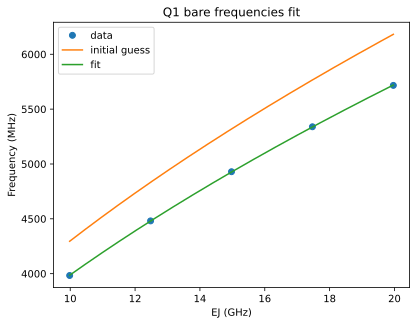

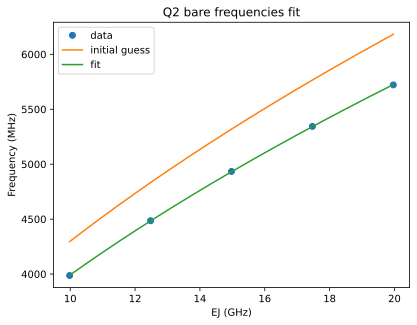

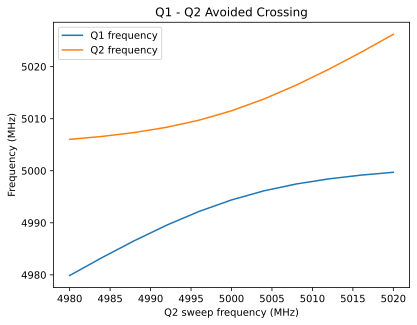

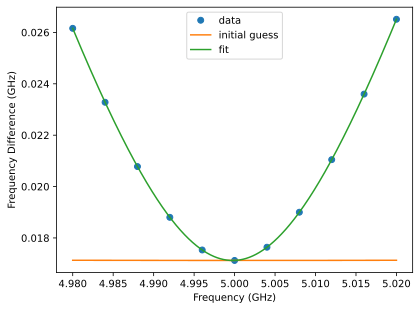

popt for coupling strength fit: [4.99976698 0.0171235  1.00036592]
coupling strength leg: 8.561751593547768 MHz
Loading graph Y_qq_rung
Found fit with the following errors:
	RMS error y11 = 0.0001017730104594457
	RMS error y12 = 1.7153311652611134e-06
	RMS error y22 = 1.0387237897426062e-05
[-2.12786217e-09+4.3126331e+10j]
[[ 2.31657284e+05+0.00000000e+00j]
 [ 2.00727347e+03+0.00000000e+00j]
 [ 2.00727347e+03+8.48091738e-13j]
 [-1.76173320e+02+0.00000000e+00j]]
1


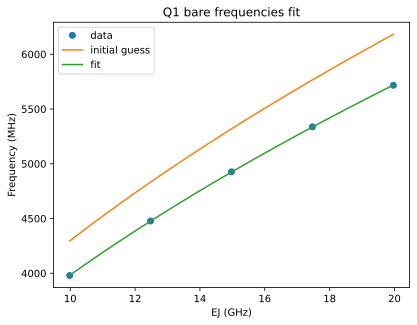

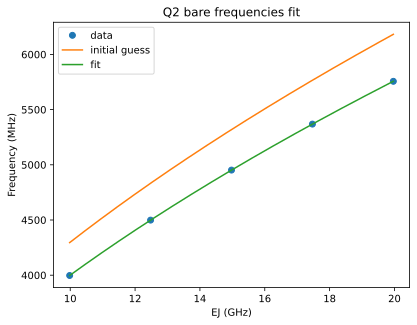

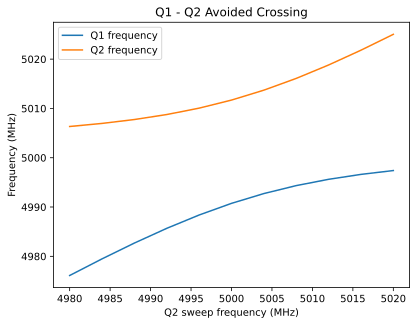

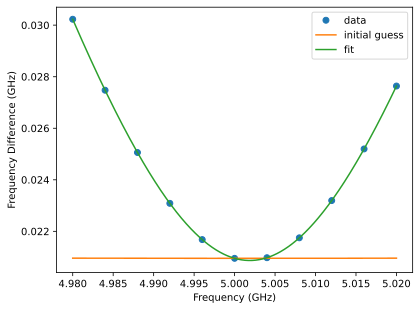

popt for coupling strength fit: [5.0018757  0.02086825 0.9998031 ]
coupling strength rung: 10.434124448355888 MHz




In [49]:
coupling_strengths_leg = []
coupling_strengths_rung = []
for i in range(len(coupler_frequencies)):
    
    coupler_frequency = coupler_frequencies[i]
    
    print(f'Setting coupler frequency to {coupler_frequency} GHz')
    
    set_coupler_frequency_equation(project, coupler_frequency*1e9)
    project.simulate_analyze()
    
    coupling_fit_initial_guess = None
    if str(coupler_frequency) in coupler_frequency_to_coupling_fit_initial_guess:
        coupling_fit_initial_guess = coupler_frequency_to_coupling_fit_initial_guess[str(coupler_frequency)]
    
    # leg coupling
    graph_name = 'Y_qq_leg'
    number_of_ports = 2
    
    coupling_strength_leg = extract_coupling_strength_from_avoided_crossing(graph_name, number_of_ports, qubit_parameters, coupler_frequency, coupling_fit_initial_guess=coupling_fit_initial_guess)
    
    print(f'coupling strength leg: {coupling_strength_leg} MHz')
    
    # rung coupling
    graph_name = 'Y_qq_rung'
    number_of_ports = 2
    
    coupling_strength_rung = extract_coupling_strength_from_avoided_crossing(graph_name, number_of_ports, qubit_parameters, coupler_frequency, coupling_fit_initial_guess=coupling_fit_initial_guess)
    
    print(f'coupling strength rung: {coupling_strength_rung} MHz')
    
    print()
    print()
    
    coupling_strengths_leg.append(coupling_strength_leg)
    coupling_strengths_rung.append(coupling_strength_rung)    
    
coupling_strengths_leg = np.array(coupling_strengths_leg)
coupling_strengths_rung = np.array(coupling_strengths_rung)

Loading graph Y_qq_leg
Found fit with the following errors:
	RMS error y11 = 1.069963270953119e-07
	RMS error y12 = 6.110811458660375e-07
	RMS error y22 = 1.0970781137890676e-07
7.0
5


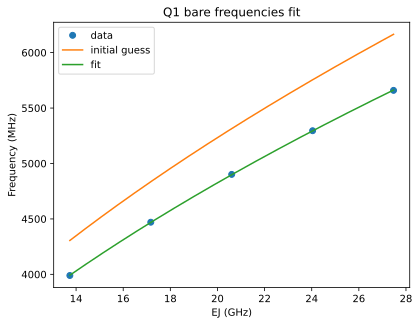

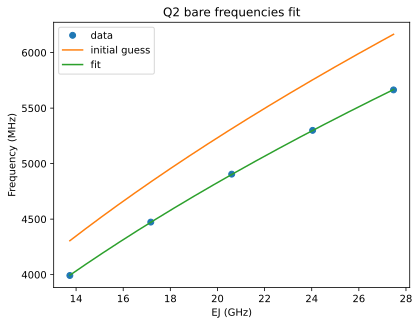

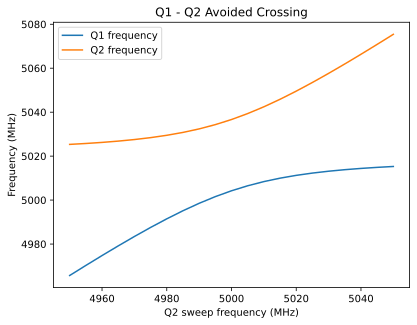

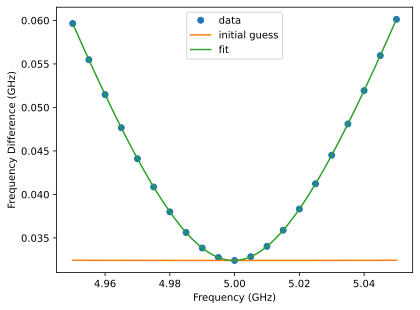

popt for coupling strength fit: [4.99970622 0.03241149 1.00717517]
Direct leg coupling: 16.205743998052984


In [349]:
### extract direct leg coupling strength when coupler is far away

set_coupler_frequency_equation(project, 12e9)
project.simulate_analyze()

# leg coupling
graph_name = 'Y_qq_leg'
number_of_ports = 2

qubit_parameters['qubit_frequency_sweep'] = np.linspace(qubit_frequency - 0.05, qubit_frequency + 0.05, 21)

coupling_strength_leg_direct = extract_coupling_strength_from_avoided_crossing(graph_name, number_of_ports, qubit_parameters, coupler_frequency, coupling_fit_initial_guess=coupling_fit_initial_guess)

print(f'Direct leg coupling: {coupling_strength_leg_direct}')

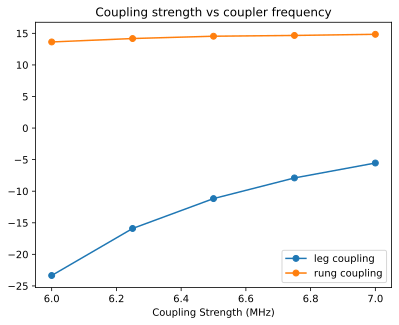

In [338]:
plt.plot(coupler_frequencies, coupling_strengths_leg, marker='o', label='leg coupling')
plt.plot(coupler_frequencies, -coupling_strengths_rung, marker='o', label='rung coupling')

plt.xlabel('Coupler Frequency (GHz)')
plt.xlabel('Coupling Strength (MHz)')

plt.title('Coupling strength vs coupler frequency')
plt.legend()
plt.show()

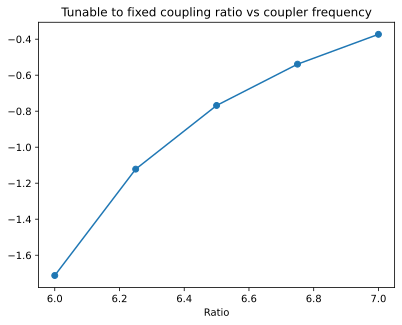

In [341]:
tunable_to_fixed_ratio = -coupling_strengths_leg/coupling_strengths_rung

plt.plot(coupler_frequencies, tunable_to_fixed_ratio, marker='o')

plt.xlabel('Coupler Frequency (GHz)')
plt.xlabel('Ratio')

plt.title('Tunable to fixed coupling ratio vs coupler frequency')
plt.show()

In [307]:
sweep_filename = r'8Q_vector_fitting_coupling_strength_sweeps\qq_leg.csv'
with open(sweep_filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['Coupler Frequency (GHz)', 'Coupling Strength (MHz)'])
    for i in range(len(coupler_frequencies)):
        writer.writerow([coupler_frequencies[i], coupling_strengths[i]])
        

In [648]:
### check eigenvalues when coupler is above and below

coupler_frequency = 6
number_of_ports = 2

set_coupler_frequency_equation(project, coupler_frequency*1e9)
project.simulate_analyze()

frequencies, y_matrix = extract_admittance_traces('Y_qq_leg', number_of_ports)
vector_fit = get_vector_fit(frequencies, y_matrix, number_of_complex_poles=1, plot_fits=False)
circuit_parameters, number_of_poles, max_rank = extract_circuit_parameters(vector_fit, number_of_ports, print_values=True)

EJ_guess = 22
junction_EJs = (EJ_guess, EJ_guess)
parasitic_capacitances = (C_parasitic_q, C_parasitic_q)
    
    


Loading graph Y_qq_leg
Found fit with the following errors:
	RMS error y11 = 4.785524276261475e-05
	RMS error y12 = 2.9685180725972492e-06
	RMS error y22 = 4.754990886004497e-05
pole 0 singular values: [8.52421808e+05 1.28812017e+01]

Pole frequencies: [5.90955219] GHz

Mode inductances (nH)
	pole 0: [36.26612238 36.26612238]

Coupling capacitances (fF)
	pole 0, rank index 0: [-3.5608768  -3.47151024]
	pole 0, rank index 1: [-0.01349489  0.01384229]

Pole capacitance to ground (fF)
	pole 0, rank index 0: 27.03238703366644 fF
	pole 0, rank index 1: 19.999652603096823 fF

proportional coefficients (fF): 
[[ 1.09048007e-28 -1.03671425e-30]
 [-1.03671425e-30  1.08991622e-28]]
Capacitance Matrix (fF)
[[113.2563804   -0.41864258]
 [ -0.41864258 113.05186871]]

Node capacitance to grounds: [112.83773782 112.63322613] fF


In [649]:
# circuit = create_qq_circuit(circuit_parameters, number_of_poles, max_rank, number_of_ports, junction_EJs, parasitic_capacitances)
circuit = create_qq_circuit_hierarchical(circuit_parameters, number_of_poles, max_rank, number_of_ports, junction_EJs, parasitic_capacitances)


In [650]:
evals_sub_1 = circuit.subsystems[1].eigenvals(5)
print((np.array(evals_sub_1[1:]) - evals_sub_1[0])*1000)

evals_sub_2 = circuit.subsystems[2].eigenvals(5)
print((np.array(evals_sub_2[1:]) - evals_sub_1[0])*1000)

[ 5939.92617528 11879.85235057 17819.77852585 23759.70470113]
[ 5894.36587555 11803.91851768 17713.47115981 23623.02380194]


In [657]:
num_evals = 2
EJ_sweep = np.linspace(21, 23, 11)
eval_data = np.zeros((len(EJ_sweep), num_evals))

for i in range(len(EJ_sweep)):
    circuit.EJ_q1 = EJ_sweep[i]

#     evals = circuit.subsystems[0].eigenvals(num_evals+1)
    evals = circuit.eigenvals(num_evals+1)

    eval_data[i,:] = (np.array(evals[1:]) - evals[0])*1000

In [658]:
print(eval_data[5,:])

[5066.87589955 5120.53758768]


In [656]:
print(eval_data[5,:])

[5120.35737515 5164.41928355]


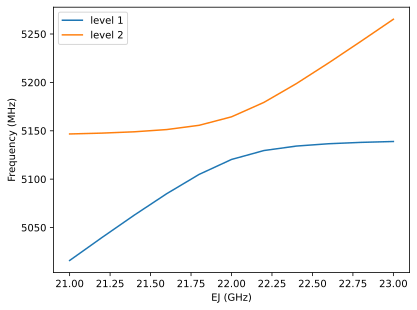

In [652]:
for i in range(num_evals):    
    plt.plot(EJ_sweep, eval_data[:,i], label=f'level {i+1}')
    
plt.xlabel('EJ (GHz)')
plt.ylabel('Frequency (MHz)')

# plt.ylim(900, 2100)

plt.legend()
plt.show()

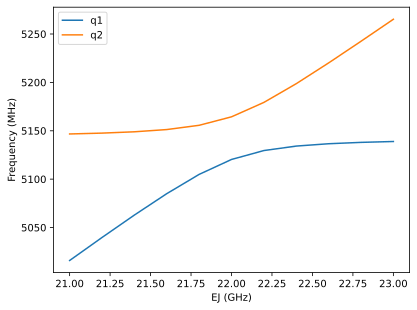

In [653]:
plt.plot(EJ_sweep, eval_data[:,0], label='q1')
plt.plot(EJ_sweep, eval_data[:,1], label='q2')

plt.xlabel('EJ (GHz)')
plt.ylabel('Frequency (MHz)')


plt.legend()
plt.show()





coupling strength: 22.03095419629608 MHz


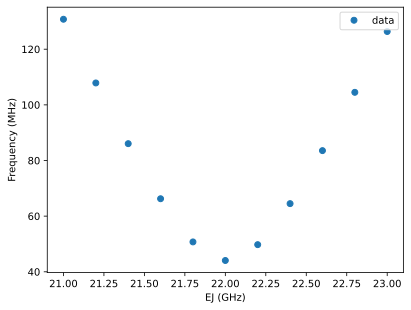

In [654]:
difference = eval_data[:,1] - eval_data[:,0]

plt.plot(EJ_sweep, difference, linestyle='', marker='o', label='data')
# plt.plot(EJ_sweep, difference, label='data')

print(f'coupling strength: {np.min(difference)/2} MHz')

plt.xlabel('EJ (GHz)')
plt.ylabel('Frequency (MHz)')

plt.legend()

plt.show()

In [655]:
coupler_frequency_below_to_rung_coupling['4']

18.119734261802478

In [498]:
# coupler_frequency_below_to_rung_coupling['4'] = np.min(difference)/2

In [507]:
coupler_frequencies_below_above = []
coupling_strengths_leg_below_above = []
coupling_strengths_rung_below_above = []

for coupler_frequency_str, strength in coupler_frequency_below_to_leg_coupling.items():
    coupler_frequencies_below_above.append(float(coupler_frequency_str))
    coupling_strengths_leg_below_above.append(strength)
    
for strength in coupler_frequency_below_to_rung_coupling.values():
    coupling_strengths_rung_below_above.append(strength)

for i in range(len(coupler_frequencies)):
    coupler_frequencies_below_above.append(coupler_frequencies[i])
    coupling_strengths_leg_below_above.append(coupling_strengths_leg[i])
    coupling_strengths_rung_below_above.append(-coupling_strengths_rung[i])    
    
coupler_frequencies_below_above = np.array(coupler_frequencies_below_above)
coupling_strengths_leg_below_above = np.array(coupling_strengths_leg_below_above)
coupling_strengths_rung_below_above = np.array(coupling_strengths_rung_below_above)

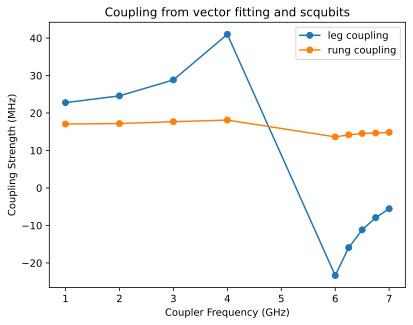

In [660]:
plt.plot(coupler_frequencies_below_above, coupling_strengths_leg_below_above, marker='o', label='leg coupling')
plt.plot(coupler_frequencies_below_above, coupling_strengths_rung_below_above, marker='o', label='rung coupling')

plt.xlabel('Coupler Frequency (GHz)')
plt.ylabel('Coupling Strength (MHz)')

plt.title('Coupling from vector fitting and scqubits')

plt.legend()
plt.show()

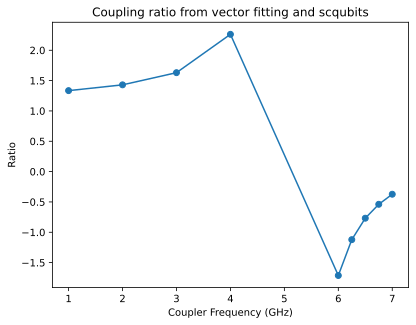

In [663]:
tunable_to_fixed_coupling_ratio_below_above = coupling_strengths_leg_below_above/coupling_strengths_rung_below_above

plt.plot(coupler_frequencies_below_above, tunable_to_fixed_coupling_ratio_below_above, marker='o')

plt.xlabel('Coupler Frequency (GHz)')
plt.ylabel('Ratio')

plt.title('Coupling ratio from vector fitting and scqubits')

plt.show()

In [543]:
### hierarchical circuit
circuit = create_qq_circuit(circuit_parameters, number_of_poles, max_rank, number_of_ports, junction_EJs, parasitic_capacitances)


In [546]:
circuit.var_categories

{'periodic': [1, 2], 'extended': [3, 4], 'free': [], 'frozen': [], 'sigma': []}

In [567]:
circuit.sym_interaction((0, 1))

<IPython.core.display.Latex object>

In [575]:
circuit.subsystem_hamiltonians[2]

0.063786995161*θ4**2 + 0.64017068718*ng1**2 + 0.640470829425*ng2**2 + 3.875287668055*Q4**2 + 0.040231555794*Q4*ng2 + 0.011065709729*ng1*ng2 - 0.039173680631*Q4*ng1

In [583]:
evals = circuit.subsystems[2].eigenvals(10)
evals = (np.array(evals) - evals[0])*1000

In [584]:
print(evals)

[   0.          994.37006337 1988.74012673 2983.1101901  3977.48025346
 4971.85031683 5966.2203802  6960.59044356 7954.96050693 8949.33057029]


In [678]:
EC_1 = 150*1e6

freq_1 = 1e9
freq_2 = 7e9

EJ_1 = (freq_1 + EC_1)**2/(8*EC_1)*1e-9
EJ_2 = (freq_2 + EC_1)**2/(8*EC_1)*1e-9

print(EJ_1)
print(EJ_2)

1.1020833333333333
42.60208333333334
